In [1]:
!pip install mujoco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 17.6 MB/s eta 0:00:00


In [2]:
#@title Check if installation was successful

from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [3]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00


""

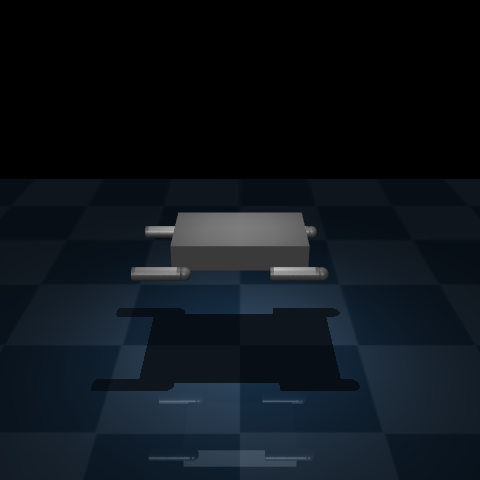

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media
import mujoco

xml_data = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
    rgb2=".2 .3 .4" width="300" height="300" mark="edge" markrgb=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true"
    reflectance=".2"/>
  </asset>
  <worldbody>
    <light pos="0 0 1" mode="trackcom"/>
    <camera name="fixed" pos="0 -2 1" xyaxes="1 0 0 0 1 2"/>
    <camera name="track" pos="0 -2 1" xyaxes="1 0 0 0 1 2" mode="track"/>

    <geom name="ground" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid" solimp=".99 .99 .01" solref=".001 1"/>

    <body name='body' pos='0 0 0'>

      <freejoint/>

      <geom name='body' type='box' mass='20' size='0.25 0.15 0.05'/>

      <body name='leg1' pos='0.197 0.175 -0.05' euler='0 90 0'>
        <joint name='hip1' type ='hinge' axis='0 -1 0' pos='0 0 0.053'/>
        <geom name='leg1' type='cylinder' mass='2' size='0.025 0.088'/>
        <body name='ankle1' pos='0.0 0 0'>
          <geom name='ankle1' type='cylinder' mass='2' size='0.025 0.075'/>
          <geom name='legball1' type='sphere' size='0.025' pos='0 0 0.1'/>
          <joint name='knee1' type ='hinge' axis='0 1 0' pos='0 0 -0.05'/>
        </body>
      </body>

      <body name='leg2' pos='0.197 -0.175 -0.05' euler='0 90 0'>
        <joint name='hip2' type ='hinge' axis='0 -1 0' pos='0 0 0.053'/>
        <geom name='leg2' type='cylinder' mass='2' size='0.025 0.088'/>
        <body name='ankle2' pos='0 0 0'>
          <geom name='ankle2' type='cylinder' mass='2' size='0.025 0.075'/>
          <geom name='legball2' type='sphere' size='0.025' pos='0 0 0.1'/>
          <joint name='knee2' type ='hinge' axis='0 1 0' pos='0 0 -0.05'/>
        </body>
      </body>

      <body name='leg3' pos='-0.303 0.175 -0.05' euler='0 90 0'>
        <joint name='hip3' type ='hinge' axis='0 -1 0' pos='0 0 0.053'/>
        <geom name='leg3' type='cylinder' mass='2' size='0.025 0.088'/>
        <body name='ankle3' pos='0.0 0 0'>
          <geom name='ankle3' type='cylinder' mass='2' size='0.025 0.075'/>
          <geom name='legball3' type='sphere' size='0.025' pos='0 0 0.1'/>
          <joint name='knee3' type ='hinge' axis='0 1 0' pos='0 0 -0.05'/>
        </body>
      </body>

      <body name='leg4' pos='-0.303 -0.175 -0.05' euler='0 90 0'>
        <joint name='hip4' type ='hinge' axis='0 -1 0' pos='0 0 0.053'/>
        <geom name='leg4' type='cylinder' mass='2' size='0.025 0.088'/>
        <body name='ankle4' pos='0.0 0 0'>
          <geom name='ankle4' type='cylinder' mass='2' size='0.025 0.075'/>
          <geom name='legball4' type='sphere' size='0.025' pos='0 0 0.1'/>
          <joint name='knee4' type ='hinge' axis='0 1 0' pos='0 0 -0.05'/>
        </body>
      </body>

    </body>
  </worldbody>

  <actuator>
    <position name='motor1' joint='hip1' kp='100'/>
    <position name='motor2' joint='hip2' kp='100'/>
    <position name='motor3' joint='hip3' kp='100'/>
    <position name='motor4' joint='hip4' kp='100'/>
    <position name='motor5' joint='knee1' kp='100'/>
    <position name='motor6' joint='knee2' kp='100'/>
    <position name='motor7' joint='knee3' kp='100'/>
    <position name='motor8' joint='knee4' kp='100'/>
  </actuator>

  <sensor>
    <actuatorfrc name='motor1frc' actuator='motor1'/>
    <actuatorfrc name='motor2frc'  actuator='motor2'/>
    <actuatorfrc name='motor3frc'  actuator='motor3'/>
    <actuatorfrc name='motor4frc'  actuator='motor4'/>
    <actuatorfrc name='motor5frc'  actuator='motor6'/>
    <actuatorfrc name='motor6frc'  actuator='motor7'/>
    <actuatorfrc name='motor7frc'  actuator='motor8'/>
    <actuatorfrc name='motor8frc'  actuator='motor8'/>
  </sensor>
</mujoco>

"""

model = mujoco.MjModel.from_xml_string(xml_data)
renderer = mujoco.Renderer(model, 480, 480)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data, "fixed")
media.show_image(renderer.render())

In [5]:
n_frames = 180 * 4
height = 240
width = 320
frames = []
fps = 60.0
times = []

motor1frc = []
motor2frc = []
motor3frc =[]
motor4frc = []
motor5frc = []
motor6frc = []
motor7frc = []
motor8frc = []

renderer = mujoco.Renderer(model, height, width)

# constant actuator signal
mujoco.mj_resetData(model, data)
data.ctrl[0] = 1
data.ctrl[1] = 1
data.ctrl[2] = 1
data.ctrl[3] = 1
data.ctrl[4] = 2
data.ctrl[5] = 2
data.ctrl[6] = 2
data.ctrl[7] = 2

# simulate and render
for i in range(n_frames):
  while data.time < i/fps:
    mujoco.mj_step(model, data)
    times.append(data.time)

    motor1frc.append(data.sensor('motor1frc').data.copy())
    motor2frc.append(data.sensor('motor2frc').data.copy())
    motor3frc.append(data.sensor('motor3frc').data.copy())
    motor4frc.append(data.sensor('motor4frc').data.copy())
    motor5frc.append(data.sensor('motor5frc').data.copy())
    motor6frc.append(data.sensor('motor6frc').data.copy())
    motor7frc.append(data.sensor('motor7frc').data.copy())
    motor8frc.append(data.sensor('motor8frc').data.copy())

  renderer.update_scene(data, "fixed")
  frame = renderer.render()
  frames.append(frame)

media.show_video(frames, fps=fps)

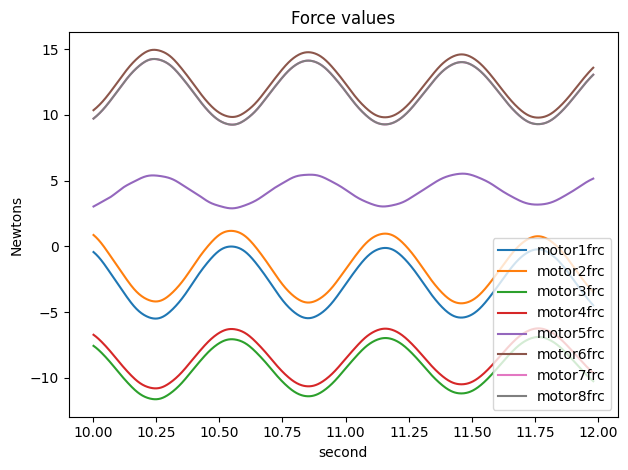

In [6]:
ax = plt.gca()
dt = 0.1
ax.plot(np.asarray(times[5000:5990]), np.asarray(motor1frc[5000:5990]), label='motor1frc'.format(1000*dt))
ax.plot(np.asarray(times[5000:5990]), np.asarray(motor2frc[5000:5990]), label='motor2frc'.format(1000*dt))
ax.plot(np.asarray(times[5000:5990]), np.asarray(motor3frc[5000:5990]), label='motor3frc'.format(1000*dt))
ax.plot(np.asarray(times[5000:5990]), np.asarray(motor4frc[5000:5990]), label='motor4frc'.format(1000*dt))
ax.plot(np.asarray(times[5000:5990]), np.asarray(motor5frc[5000:5990]), label='motor5frc'.format(1000*dt))
ax.plot(np.asarray(times[5000:5990]), np.asarray(motor6frc[5000:5990]), label='motor6frc'.format(1000*dt))
ax.plot(np.asarray(times[5000:5990]), np.asarray(motor7frc[5000:5990]), label='motor7frc'.format(1000*dt))
ax.plot(np.asarray(times[5000:5990]), np.asarray(motor8frc[5000:5990]), label='motor8frc'.format(1000*dt))

# finalize plot
ax.set_title('Force values')
ax.set_ylabel('Newtons')
ax.set_xlabel('second')
ax.legend(frameon=True, loc='lower right');
plt.tight_layout()

In [7]:
len(motor8frc)

5992

In [8]:
max(motor8frc[5000:5990])

array([14.262])

In [9]:
max(motor5frc[5000:5990])

array([5.535])

In [10]:
max(motor7frc[5000:5990])

array([14.262])

In [11]:
"""
motor 7 = motor 8 knee back
motor 5 = motor 6 knee front
motor 3 = motor 4 hip back (take minimum)
motor 2 = motor 1 hip front (take minimum)
"""

print('max torque hip front', min(motor1frc[5000:5990]) * 0.15, 'nm')
print('max torque hip back', min(motor3frc[5000:5990]) * 0.15, 'nm')
print('max torque knee front', max(motor5frc[5000:5990]) * 0.15, 'nm')
print('max torque knee back', max(motor7frc[5000:5990]) * 0.15, 'nm')

max torque hip front [-0.824] nm
max torque hip back [-1.745] nm
max torque knee front [0.83] nm
max torque knee back [2.139] nm
